In [1]:
import os
from bagpy import bagreader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R

/home/zozan/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def list_files_with_full_path(folder_path):
    try:
        # Get the list of files in the folder with full paths
        files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        return files
    except OSError as e:
        print(f"Error reading files in {folder_path}: {e}")
        return None
    
def get_csv(bag_name):
    
    data_dict = {}
    
    # Read bag
    b = bagreader(bag_name)
    
    for topic in b.topics: 
        data = b.message_by_topic(topic)
        data_dict['{}'.format(topic)] = pd.read_csv(data)
        
    return data_dict

def get_name(search, list_of_names): 
    
    for i, name in enumerate(list_of_names): 
        if search in name: 
            return name

# Transform stuff
def create_T(p, q): 
    
    r = R.from_quat([q[0], q[1], q[2], q[3]])
    r = r.as_matrix()
                     
    T = np.matrix([[r[0, 0], r[0, 1], r[0, 2], p[0]], 
                   [r[1, 0], r[1, 1], r[1, 2], p[1]],
                   [r[2, 0], r[2, 1], r[2, 2], p[2]], 
                   [0, 0, 0, 1]])
    return T
                 
def get_p_from_T(T_0P):
    
    x = [T_0P_[0, 3] for T_0P_ in T_0P]
    y = [T_0P_[1, 3] for T_0P_ in T_0P]
    z = [T_0P_[2, 3] for T_0P_ in T_0P]
    
    return(x, y, z)

def transform_to_marker_tip(x, y, z, qx, qy, qz, qw, T_TP): 
    
    T_0T = [create_T((x_, y_, z_), (qx_, qy_, qz_, qw_)) for x_, y_, z_, qx_, qy_, qz_, qw_ in zip(x, y, z, qx, qy, qz, qw)]
    T_0P = [np.dot(T_0T_, T_TP) for T_0T_ in T_0T]
    
    x, y, z = get_p_from_T(T_0P)
    
    return x, y, z 

def extract_kalipen(csv, trace):
    if trace: 
        topic_name = '/kdno/MARKER_COLOR'
    else: 
        topic_name = '/kdno/MARKER_BW'
        
    t = csv[topic_name]['Time']
    x = csv[topic_name]['pose.position.x']
    y = csv[topic_name]['pose.position.y']
    z = csv[topic_name]['pose.position.z']
    
    return (x, y, z)

def extract_robot(csv, T_TP):
    # Same topic name for both recordings
    x = csv['/franka_state_controller/O_T_EE']['pose.position.x'] 
    y = csv['/franka_state_controller/O_T_EE']['pose.position.y']
    z = csv['/franka_state_controller/O_T_EE']['pose.position.z'] 
    qx = csv['/franka_state_controller/O_T_EE']['pose.orientation.x']
    qy = csv['/franka_state_controller/O_T_EE']['pose.orientation.y']
    qz = csv['/franka_state_controller/O_T_EE']['pose.orientation.z']
    qw = csv['/franka_state_controller/O_T_EE']['pose.orientation.w']
    
    x_, y_, z_ = transform_to_marker_tip(x, y, z, qx, qy, qz, qw, T_TP)
    
    return (x_, y_, z_)


def plot_results(p_mc, p_mnc, p_rc, p_rnc, save_=False):
    # Create a subplot with a 1x2 grid
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    
    # Get data from position vectors
    x_mc, y_mc, z_mc = p_mc[0], p_mc[1], p_mc[2]
    x_mnc, y_mnc, z_mnc = p_mnc[0], p_mnc[1], p_mnc[2]
    x_rc, y_rc, z_rc = p_rc[0], p_rc[1], p_rc[2]
    x_rnc, y_rnc, z_rnc = p_rnc[0], p_rnc[1], p_rnc[2]

    # Plot the first graph on the left
    axes[0].plot(x_mc, z_mc, color='red', label='Kalipen trace')
    axes[0].plot(x_mnc, z_mnc, color='green', label='Kalipen no trace')
    axes[0].set_title('Kalipen results')
    axes[0].set_xlabel('X [m]')
    axes[0].set_ylabel('Z [m]')
    axes[0].legend()
    axes[0].grid()

    # Plot the second graph on the right
    axes[1].plot(y_rc, z_rc, color='yellow', label='Robot trace')
    axes[1].plot(y_rnc, z_rnc, color='orange', label='Robot no trace')
    axes[1].set_title('Robot marker results')
    axes[1].set_xlabel('X [m]')
    axes[1].set_ylabel('Z [m]')
    axes[1].legend()
    axes[1].grid()

    # Adjust layout for better spacing
    plt.tight_layout()
    # Show the plot
    plt.show()
    
    if save_:
        plt.savefig('./myresults.png')
        
def plot_blackboard(p_mc, p_nc, p_rc, p_rnc, save_=False):
    
    # Get data from position vectors
    x_mc, y_mc, z_mc = p_mc[0], p_mc[1], p_mc[2]
    x_mnc, y_mnc, z_mnc = p_mnc[0], p_mnc[1], p_mnc[2]
    x_rc, y_rc, z_rc = p_rc[0], p_rc[1], p_rc[2]
    x_rnc, y_rnc, z_rnc = p_rnc[0], p_rnc[1], p_rnc[2]
    
    plt.figure(figsize=(15, 10))
    plt.plot(x_mc, z_mc, label='Kalipen TRACE')
    plt.plot(x_mnc, z_mnc, label='Kalipen NO TRACE')
    plt.plot(y_rc, z_rc, label="Robot TRACE")
    plt.plot(y_rnc, z_rnc, label="Robot NO TRACE")
    plt.xlabel('X [m]')
    plt.ylabel('Z [m]')
    plt.title('Blackboard of the experiment')
    plt.legend()
    plt.grid()
    
    if save_: 
        plt.savefig('./myblackboard')


    

T_TP = np.matrix([[1, 0, 0, 0.0015946], 
                  [0, 1, 0, -0.00069987], 
                  [0, 0, 1, 0.14166], 
                  [0, 0, 0, 1]])




In [3]:
list_of_bags1 = list_files_with_full_path("./pbd_bags/student11")
list_of_bags2 = list_files_with_full_path("./pbd_bags/student12")
list_of_bags3 = list_files_with_full_path("./pbd_bags/student13")

In [4]:
bags = [bagreader(bag) for bag in list_of_bags3]

[INFO]  Data folder ./pbd_bags/student13/student_91_MARKER_BW already exists. Not creating.
[INFO]  Data folder ./pbd_bags/student13/student_91_color_robot already exists. Not creating.
[INFO]  Data folder ./pbd_bags/student13/student_91_bw_robot already exists. Not creating.
[INFO]  Data folder ./pbd_bags/student13/student_91_MARKER_COLOR already exists. Not creating.


In [5]:
# Plots marker movement in space
csv_k_trace = get_csv(get_name('MARKER_COLOR', list_of_bags1))
csv_k_ntrace = get_csv(get_name('MARKER_BW', list_of_bags1))
csv_r_trace = get_csv(get_name('color_robot', list_of_bags1))
csv_r_ntrace = get_csv(get_name('bw_robot', list_of_bags1))

p_mc = extract_kalipen(csv_k_trace, trace=True)
p_mnc = extract_kalipen(csv_k_ntrace, trace=False)

p_rc = extract_robot(csv_r_trace, T_TP)
p_rnc =  extract_robot(csv_r_ntrace, T_TP)

[INFO]  Data folder ./pbd_bags/student11/student_11_MARKER_COLOR already exists. Not creating.
[INFO]  Data folder ./pbd_bags/student11/student_11_MARKER_BW already exists. Not creating.
[INFO]  Data folder ./pbd_bags/student11/student_11_color_robot already exists. Not creating.
[INFO]  Data folder ./pbd_bags/student11/student_11_bw_robot already exists. Not creating.


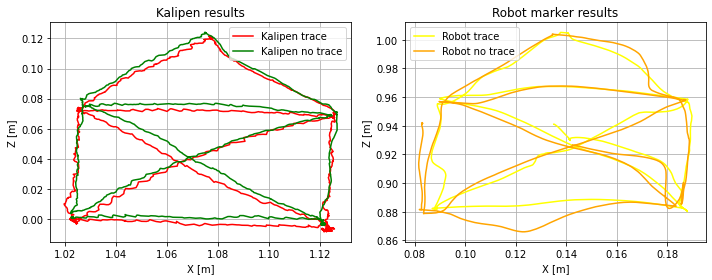

In [6]:
plot_results(p_mc, p_mnc, p_rc, p_rnc)

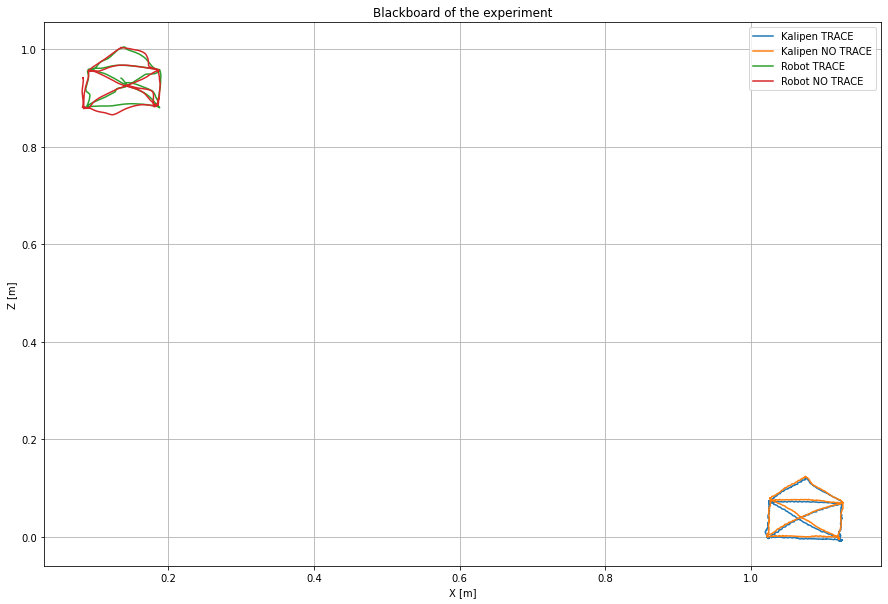

In [7]:
plot_blackboard(p_mc, p_mnc, p_rc, p_rnc, save_=True)

In [8]:
def extract_joint_pos(csv, topic): 
    t = csv[topic]['Time'] - min(csv[topic]['Time'])
    q0 = csv[topic]['position_0']
    q1 = csv[topic]['position_1']
    q2 = csv[topic]['position_2']
    q3 = csv[topic]['position_3']
    q4 = csv[topic]['position_4']
    q5 = csv[topic]['position_5']
    q6 = csv[topic]['position_6']
    q = [q0, q1, q2, q3, q4, q5, q6]
    return t, q


In [9]:
t, q = extract_joint_pos(csv_r_trace, '/joint_states')

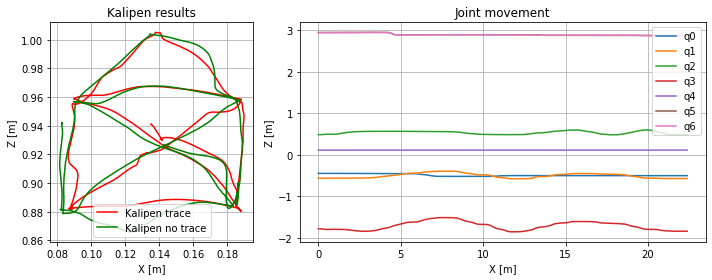

In [10]:
# Create a subplot with a 1x2 grid
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 2]})
    
x_rc, y_rc, z_rc = p_rc[0], p_rc[1], p_rc[2]
x_rnc, y_rnc, z_rnc = p_rnc[0], p_rnc[1], p_rnc[2]

# Plot the first graph on the left
axes[0].plot(y_rc, z_rc, color='red', label='Kalipen trace')
axes[0].plot(y_rnc, z_rnc, color='green', label='Kalipen no trace')
axes[0].set_title('Kalipen results')
axes[0].set_xlabel('X [m]')
axes[0].set_ylabel('Z [m]')
axes[0].legend()
axes[0].grid()

# Plot the second graph on the right
axes[1].plot(t, q[0], label='q0')
axes[1].plot(t, q[1], label='q1')
axes[1].plot(t, q[2], label='q2')
axes[1].plot(t, q[3], label='q3')
axes[1].plot(t, q[4], label='q4')
axes[1].plot(t, q[5], label='q5')
axes[1].plot(t, q[5], label='q6')
axes[1].set_title('Joint movement')
axes[1].set_xlabel('X [m]')
axes[1].set_ylabel('Z [m]')
axes[1].legend()
axes[1].grid()

# Adjust layout for better spacing
plt.tight_layout()
# Show the plot
plt.show()

## TODO: 

- [x] Read bags 
- [x] Plot first house
- [x] Plot second house
- [x] Add TF flandza-pen
- [x] Making house plotting autonomous
- [ ] Add in one script for autonomous plot
- [ ] Add plotting of the joint states

## User study plots


 ### TODO: 
 - [x] Import CSV data
 - [x] Plot polar 
 - [ ] Plot bar plot 
 - [ ] Calculate std dev
 - [ ] Read all bags and extract times for each student 
 - [ ] Maybe compare temporal demand and times
 - [ ] Plot initial CSV data 
 - [ ] Sort data based on the task

In [11]:
import pandas as pd

# Replace 'your_file.csv' with the actual path to your CSV file
sus_pbd = './sus_data.csv'
nasa_tlx_pbd = './nasa_rtlx_data.csv'

# Load the CSV file into a pandas DataFrame
sus_pbd_data = pd.read_csv(sus_pbd)
nasa_tlx_pbd_data = pd.read_csv(nasa_tlx_pbd)

In [44]:
k_trace_ntlx = nasa_tlx_pbd_data[nasa_tlx_pbd_data['Task'].str.contains('Calipen - Trace')]
k_ntrace_ntlx = nasa_tlx_pbd_data[nasa_tlx_pbd_data['Task'].str.contains('Calipen - No Trace')]
r_trace_ntlx = nasa_tlx_pbd_data[nasa_tlx_pbd_data['Task'].str.contains('Robot - Trace')]
r_ntrace_ntlx = nasa_tlx_pbd_data[nasa_tlx_pbd_data['Task'].str.contains('Robot - No Trace')]

In [69]:
k_trace_ntlx[k_trace_ntlx['Task'].str.contains('Calipen - Trace')]
#k_trace_ntlx.drop('Timestamp')
k_trace_ntlx['MD'].sum()

44

0      1
4      1
8      2
14     2
18     1
22     2
23     1
27     2
32     3
36     2
40     1
44     3
49     1
53     2
58     1
62     1
66     1
68     1
73     1
77     3
81     3
84     1
88     1
92     2
95     3
101    2
Name: MD, dtype: int64

## NASA rTLX comparison

In [70]:
def extract_categories(sum_): 
    return {"e": sum_.E, "f": sum_.F, "p": sum_.P, "pd": sum_.PD, "td": sum_.TD, "md": sum_.MD}

def divide_dict_values(sum_, N):
    dct_ = extract_categories(sum_)
    return {key: value / N for key, value in dct_.items()}

def get_avg(df): 
    return [df["MD"].sum()/len(df["MD"]), 
            df["PD"].sum()/len(df["PD"]), 
            df["TD"].sum()/len(df["TD"]), 
            df["F"].sum()/len(df["F"]), 
            df["P"].sum()/len(df["P"]), 
            df["E"].sum()/len(df["E"])]

In [77]:
avg_ktrace = get_avg(k_trace_ntlx)
avg_nktrace = get_avg(k_ntrace_ntlx)
avg_rtrace = get_avg(r_trace_ntlx)
avg_nrtrace = get_avg(r_ntrace_ntlx)

In [99]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'polar'}]*2])

rtlx_short_cats = ["MD", "PD", "TD", "F", "P", "E"]

fig.add_trace(go.Scatterpolar(
        name='kalipen trace',
        r = list(avg_ktrace),
        theta = rtlx_short_cats,
        marker_symbol = "square", 
        fill='toself', 
        subplot='polar1'
    ), 1, 1)

fig.add_trace(go.Scatterpolar(
        name='kalipen no trace',
        r = list(avg_nktrace),
        theta = rtlx_short_cats,
        marker_symbol = "square", 
        fill='toself', 
        subplot='polar1'
    ), 1, 1)
fig.add_trace(go.Scatterpolar(
        name='robot trace', 
        r = list(avg_rtrace),
        theta = rtlx_short_cats,
        marker_symbol = "square", 
        fill='toself', 
        subplot='polar2'
    ), 1, 2)
fig.add_trace(go.Scatterpolar(
        name='robot no trace', 
        r = list(avg_nrtrace),
        theta = rtlx_short_cats,
        marker_symbol = "square", 
        fill='toself', 
        subplot='polar2'
    ), 1, 2)

fig.update_layout(
    title='NASA RTLX comparison', 
    font_size=12, 
    showlegend=True)

!pip install plotly